In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Traiter les erreurs

In [2]:
data = pd.read_csv('./resources/operations.csv')
data

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE
...,...,...,...,...,...
304,2023-10-05,CARTE XX XX XX XX XX XX,-10.64,2440.94,AUTRE
305,2023-10-05,CARTE XX XX XX XX,-4.80,2430.30,AUTRE
306,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2425.50,COTISATION BANCAIRE
307,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00,2423.58,RESTAURANT


Le dataset représente l'historique des opérations bancaire d'un client. Il possède 309 opérations décritent sur 5 variables.

Il y a comme variable :

 - date_operation : La date où l'opération a été effectuée.
 - libelle : libellé de l'opération
 - montant : montant du crédit (valeur positive) ou du débit (valeur négative) de l'opération.
 - solde_avt_ope : solde du compte avant l'opération.
 - categ : libellé de la catégorie correspondant à l'opération.




In [3]:
# Vérifications du typage des variables
data.dtypes

date_operation     object
libelle            object
montant           float64
solde_avt_ope     float64
categ              object
dtype: object

Ici on remarque que la colonne "date_operation" n'est pas au format datetime.On peut corriger cela via la méthode <b>pd.to_datetime</b>. Mais l'idéal est de vérifier si toutes les dates sont dans le même format. Avant de modifier le type.

In [4]:
data['date_operation'] = pd.to_datetime(data['date_operation'], errors='coerce')
data.dtypes

date_operation    datetime64[ns]
libelle                   object
montant                  float64
solde_avt_ope            float64
categ                     object
dtype: object

In [5]:
# Les valeurs manquantes
print(data.isnull().sum())

date_operation    0
libelle           0
montant           2
solde_avt_ope     0
categ             1
dtype: int64


On constate que notre jeu de données possède trois valeurs manquante. Deux pour la colonne "montant" et une pour la colonne "categ".

In [6]:
data.loc[ data['montant'].isnull(), : ]

,date_operation,libelle,montant,solde_avt_ope,categ
107,2023-06-12,CARTE XX XX LES ANCIENS ROBINSON XX,NaN,4667.19,COURSES
269,2023-09-11,CARTE XX XX XX XX,NaN,3401.93,AUTRE


In [7]:
data.loc[ data['categ'].isnull(), : ]

,date_operation,libelle,montant,solde_avt_ope,categ
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN


Pour corriger les valeurs manquantes de la colonne "montant" on peut les deviner grâce à la colonne "solde_avt_ope". 
On effectue la différence entre la valeur "solde_avt_ope" de l'opération qui suit de l'opération où la valeur est manquante. 

In [8]:
for i in data.loc[ data['montant'].isnull(), : ].index:    
    diff = data.loc[ i+1, 'solde_avt_ope' ] - data.loc[ i, 'solde_avt_ope' ]
    data.loc[ i, 'montant' ] = round(diff,2)



Pour corriger la valeur manquante de la catégorie, on va checker si le libellé utilisé pour l'opération existe déjà dans le dataset pour une autre opération. 

In [9]:
data.loc[ data['libelle'] == "PRELEVEMENT XX TELEPHONE XX XX" ]

,date_operation,libelle,montant,solde_avt_ope,categ
8,2023-04-05,PRELEVEMENT XX TELEPHONE XX XX,-7.02,2056.02,FACTURE TELEPHONE
62,2023-05-09,PRELEVEMENT XX TELEPHONE XX XX,-7.02,4090.10,FACTURE TELEPHONE
102,2023-06-07,PRELEVEMENT XX TELEPHONE XX XX,-6.38,4688.91,FACTURE TELEPHONE
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN
204,2023-08-07,PRELEVEMENT XX TELEPHONE XX XX,-7.46,3751.73,FACTURE TELEPHONE
260,2023-09-05,PRELEVEMENT XX TELEPHONE XX XX,-6.38,3453.96,FACTURE TELEPHONE
308,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2413.58,FACTURE TELEPHONE


On remarque que le libellé "PRELEVEMENT XX TELEPHONE XX XX" est associé pour la catégorie "FACTURE TELEPHONE". Dans ce cas on peut directement affecter la valeur "FACTURE TELEPHONE" à notre valeur manquante.

In [10]:
data.loc[ data['categ'].isnull(), "categ" ] = "FACTURE TELEPHONE"

Pour déterminer si il y a présence de doublon, il faut un identifiant unique. Ici il n'y en a pas. On va en créer un. On part du principe où une opération est représenté par une date, un libellé, un montant et un solde avant montant. En effet il est impossible que pour une même date, on effectue deux fois la même opération avec un solde avant opération identique.

Ce qui donne :

In [11]:
# Doublons
data.loc[ data[ ['date_operation', 'libelle', 'montant', 'solde_avt_ope'] ].duplicated(keep=False), : ]

,date_operation,libelle,montant,solde_avt_ope,categ
43,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES
44,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES


Dans ce cas on supprime un des deux doublons.

In [12]:
# Suppression de doublon
data.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], inplace=True, ignore_index=True)

Une technique simpliste pour repérer les valeurs outliers est d'utiliser la méthode .describe() du dataframe.

In [13]:
# Desciption du dataframe
data.describe()

,date_operation,montant,solde_avt_ope
count,308,308.000000,308.000000
mean,2023-07-05 10:59:13.246753280,-45.782013,3395.301071
min,2023-03-31 00:00:00,-15000.000000,1416.810000
25%,2023-05-21 06:00:00,-20.447500,3010.737500
50%,2023-07-05 12:00:00,-9.600000,3452.465000
75%,2023-08-21 00:00:00,-2.715000,3787.232500
max,2023-10-06 00:00:00,1071.600000,4709.310000
std,NaN,872.818105,667.109412


On remarque une valeur minimum de -15000 pour la variable "montant".

In [14]:
data.loc[ data['montant'] == -15000 ]

,date_operation,libelle,montant,solde_avt_ope,categ
198,2023-08-03,CARTE XX XX XX XX,-15000.0,3797.35,AUTRE


Curieuse cette opération, on va vérifier que le solde_avt_ope évolue en conséquence.

In [15]:
index = data.loc[ data['montant'] == -15000 ].index[0]
data.iloc[ index-1:index+2, : ]

,date_operation,libelle,montant,solde_avt_ope,categ
197,2023-08-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,3121.35,AUTRE
198,2023-08-03,CARTE XX XX XX XX,-15000.00,3797.35,AUTRE
199,2023-08-03,CARTE XX XX L'EPICERIE DEMBAS XX XX,-10.51,3782.96,AUTRE


On remarque ainsi que l'opération suivante ne possède pas un solde_avt_ope de (3797.35 + (-15000)) = -11202.65 mais un solde_avt_ope de 3782.96 soit en réalité une différence de 3782.96 - 3797.35 = -14.39

On peut donc corriger le montant abérant par le bon montant.

In [16]:
data.loc[data['montant']==-15000, 'montant'] = -14.39

In [17]:
data.describe()

,date_operation,montant,solde_avt_ope
count,308,308.000000,308.000000
mean,2023-07-05 10:59:13.246753280,2.872565,3395.301071
min,2023-03-31 00:00:00,-602.270000,1416.810000
25%,2023-05-21 06:00:00,-20.047500,3010.737500
50%,2023-07-05 12:00:00,-9.600000,3452.465000
75%,2023-08-21 00:00:00,-2.715000,3787.232500
max,2023-10-06 00:00:00,1071.600000,4709.310000
std,NaN,176.089858,667.109412


La description du df semble correct.

On pourrait aller plus loin en créant une fonction qui aurait pour but de contrôler les différences entre les solde_avt_ope de chaque ligne afin de vérifier l'exactitude des montants des opérations.

In [18]:
data.to_csv('./resources/operations-cleaned.csv', index=False)

### Analyse de la variable montant

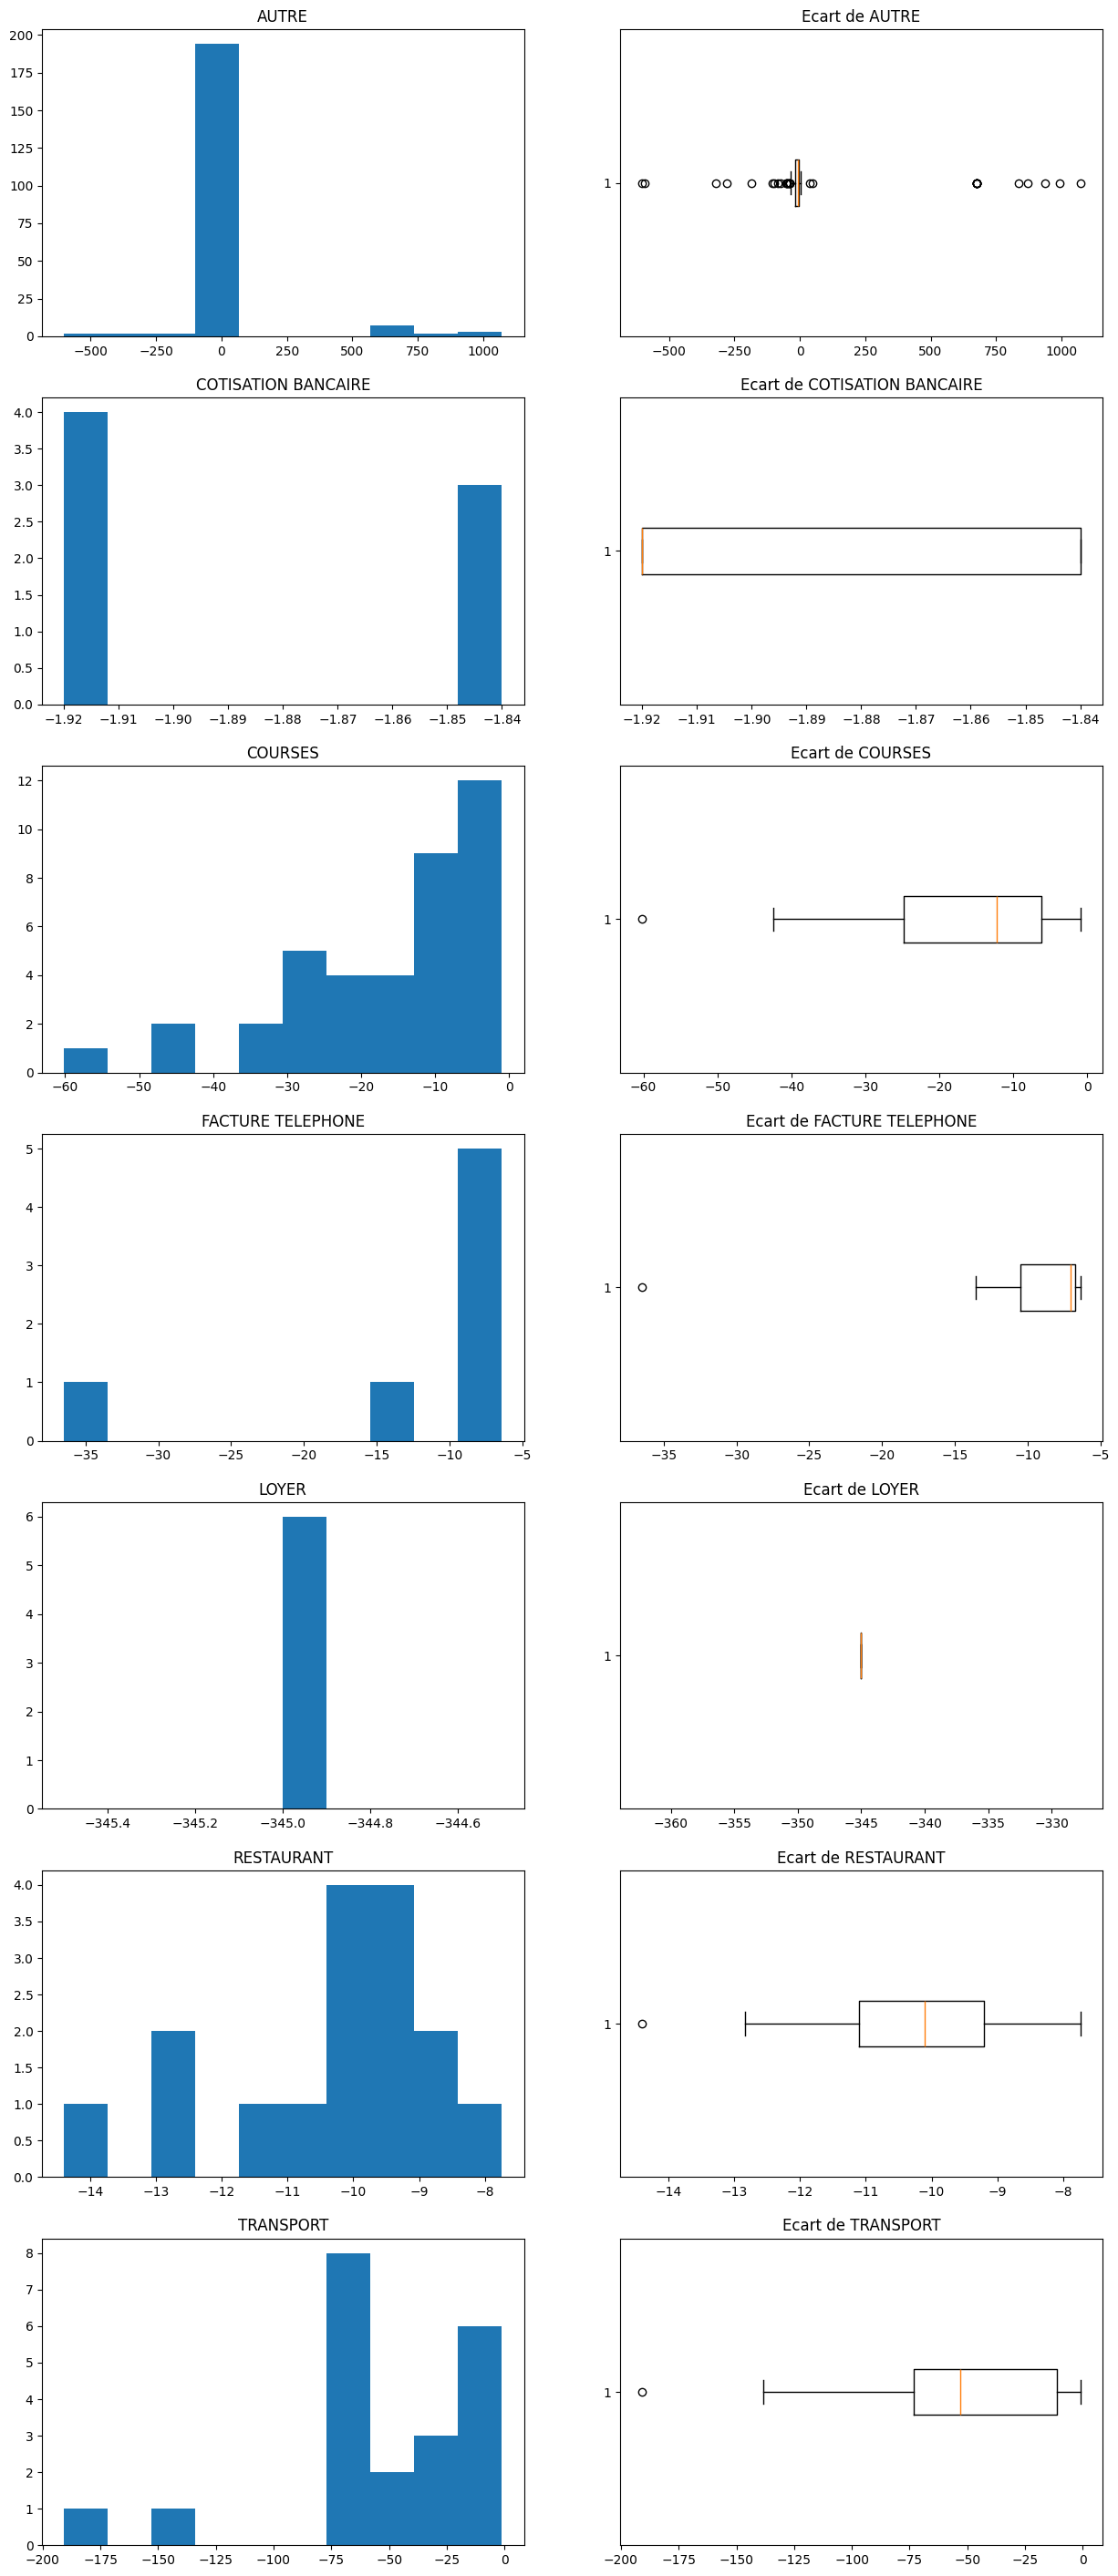

,categorie,mean,mode,median,variance,ecart-type,coef variation,skewness,kurtosis
0,AUTRE,23.43,-1.60,-8.31,40593.31,201.48,8.60,3.12,12.72
1,COTISATION BANCAIRE,-1.89,-1.92,-1.92,0.00,0.04,-0.02,0.37,-2.80
2,COURSES,-16.34,-60.16,-12.24,181.68,13.48,-0.82,-1.25,1.60
3,FACTURE TELEPHONE,-12.05,-7.02,-7.02,122.52,11.07,-0.92,-2.39,5.80
4,LOYER,-345.00,-345.00,-345.00,0.00,0.00,-0.00,0.00,0.00
5,RESTAURANT,-10.33,-9.20,-10.10,3.04,1.74,-0.17,-0.89,0.60
6,TRANSPORT,-53.00,-73.00,-53.10,2315.27,48.12,-0.91,-1.25,2.19


In [77]:
# Analyse du mode, moyenne, mediane du montant pour chaque catégorie

categories = data.groupby('categ').count().reset_index()['categ']
list = []

# nb_row = math.ceil(len(categories) / 2)
nb_row = len(categories)

figure, axis = plt.subplots(nb_row, 2)
figure.set_figwidth(15)
figure.set_figheight(20)

row = 0
col = 0

for i, c in enumerate(categories):   
    
    d = data.loc[ data['categ'] == c ]['montant']
    mean = round(d.mean(), 2)
    mode = round(d.mode(), 2)
    median = round(d.median(), 2)
    variance = round(d.var(), 2)
    ecart_type = round(d.std(), 2)
    coeff_var = round((ecart_type / mean), 2)
    skewness = round(d.skew(),2)
    kurtosis = round(d.kurtosis(),2)

    list.append([c, mean, mode.iloc[0], median, variance, ecart_type, coeff_var, skewness, kurtosis])

    axis[row, 0].hist(x=d)
    axis[row, 0].set_title(c)
    
    axis[row, 1].boxplot(x=d, vert=False)
    axis[row, 1].set_title("Ecart de " + c)

    # On décale l'affichage des prochains graph un peu plus bas.
    plt.subplots_adjust(bottom=-0.5 )

    # axis[row, col].hist(x=d)
    # axis[row, col].set_title(c)

    # if i % 2 == 0:
    #     col += 1
    # else:        
    #     row += 1
    #     col -= 1

    row += 1
        
        
tab = pd.DataFrame(list, columns=['categorie', 'mean', 'mode', 'median', 'variance', 'ecart-type', 'coef variation', 'skewness', 'kurtosis'])

plt.show()
tab

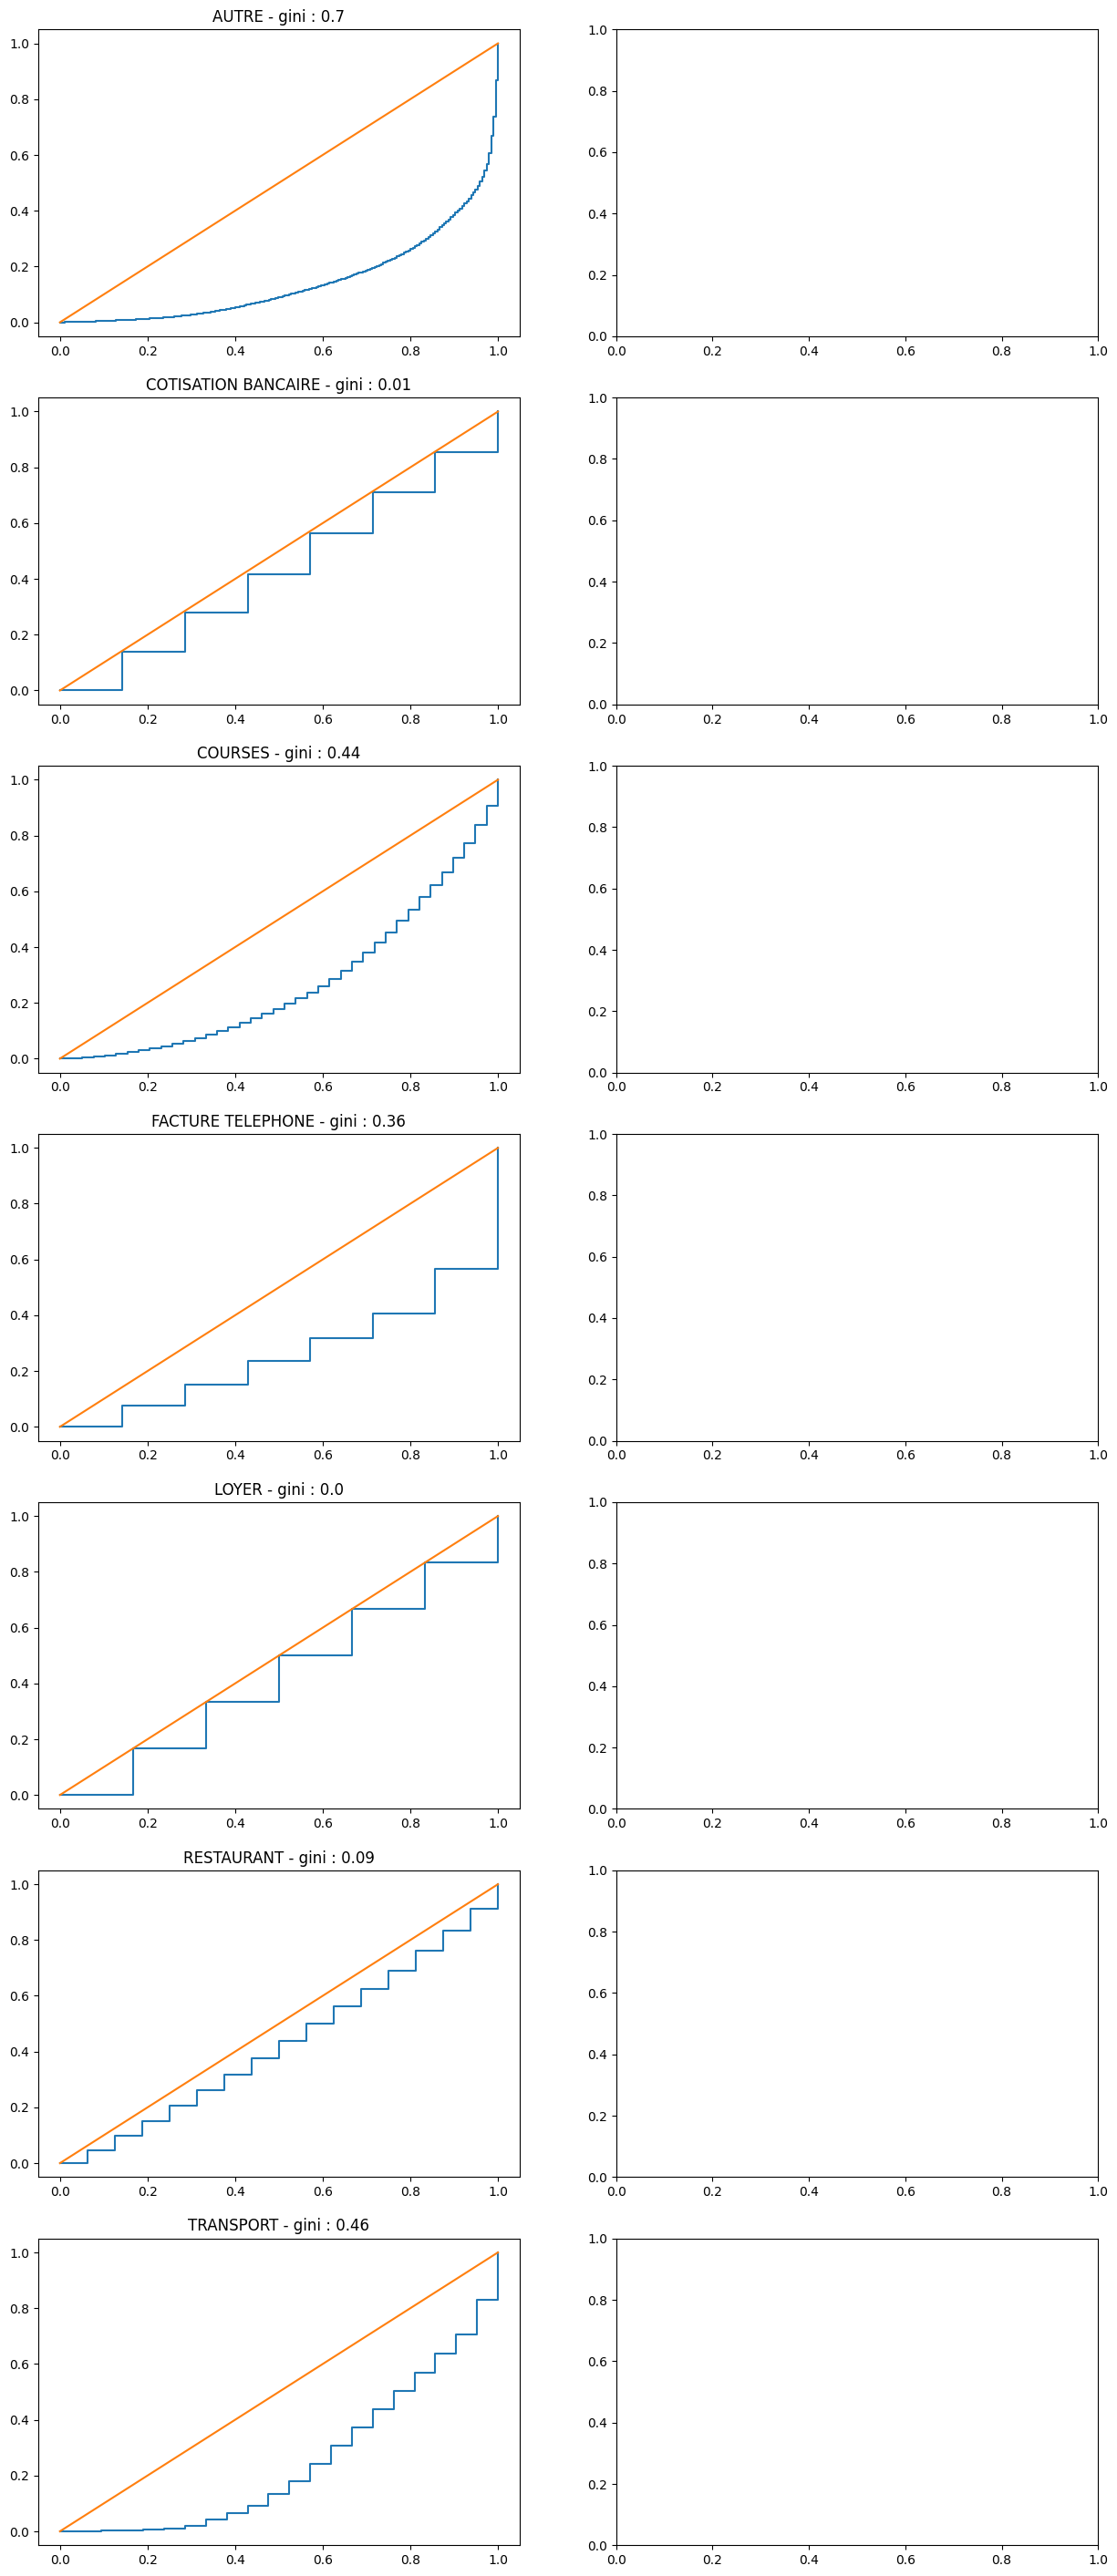

In [95]:
figure, axis = plt.subplots(nb_row, 2)
figure.set_figwidth(15)
figure.set_figheight(20)

row = 0
col = 0

for i, c in enumerate(categories):   
    
    d = data.loc[ data['categ'] == c ]

    depenses = d[d['montant'] < 0]
    dep = -depenses['montant'].values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz)
    xaxis = np.linspace(0,1,len(lorenz))

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
    S = 0.5 - AUC 
    gini = 2*S
    
    axis[row, 0].plot(xaxis,lorenz,drawstyle='steps-post')
    axis[row, 0].plot([0,1], [0,1])
    axis[row, 0].set_title(c + " - gini : " + str(round(gini,2)) )    

    # On décale l'affichage des prochains graph un peu plus bas.
    plt.subplots_adjust(bottom=-0.5 )    

    row += 1
       
plt.show()
